In [1]:
# Distributionally Robust End-to-End Portfolio Construction
# Experiment 1 - General
####################################################################################################
# Import libraries
####################################################################################################
import torch
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.close("all")

# Make the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Import E2E_DRO functions
from e2edro import e2edro as e2e
from e2edro import DataLoad as dl
from e2edro import BaseModels as bm
from e2edro import PlotFunctions as pf

# Path to cache the data, models and results
# cache_path = "./cache/exp/"
cache_path = "C:\\Users\\Rafay\Documents\\thesis\\ActualWork\\Backtester\\E2E-DRO\\cache\\exp\\"
####################################################################################################
# Experiments 1-4 (with hisotrical data): Load data
####################################################################################################

# Data frequency and start/end dates
freq = 'weekly'
start = '2000-01-01'
end = '2021-09-30'

# Train, validation and test split percentage
split = [0.6, 0.4]

# Number of observations per window 
n_obs = 104

# Number of assets
n_y = 20

# AlphaVantage API Key. 
# Note: User API keys can be obtained for free from www.alphavantage.co. Users will need a free 
# academic or paid license to download adjusted closing pricing data from AlphaVantage.
AV_key = 'W5ACAYR6PEX7L28T'

# Historical data: Download data (or load cached data)
X, Y = dl.AV(start, end, split, freq=freq, n_obs=n_obs, n_y=n_y, use_cache=True,
            save_results=False, AV_key=AV_key)

# Number of features and assets
n_x, n_y = X.data.shape[1], Y.data.shape[1]

####################################################################################################
# E2E Learning System Run
####################################################################################################

#---------------------------------------------------------------------------------------------------
# Initialize parameters
#---------------------------------------------------------------------------------------------------

# Performance loss function and performance period 'v+1'
perf_loss='sharpe_loss'
perf_period = 13

# Weight assigned to MSE prediction loss function
pred_loss_factor = 0.5

# Risk function (default set to variance)
prisk = 'p_var'

# Robust decision layer to use: hellinger or tv
dr_layer = 'hellinger'

# List of learning rates to test
lr_list = [0.005, 0.0125, 0.02]

# List of total no. of epochs to test
epoch_list = [30, 40, 50, 60, 80, 100]

# For replicability, set the random seed for the numerical experiments
set_seed = 1000

# Load saved models (default is False)
use_cache = False

#---------------------------------------------------------------------------------------------------
# Run 
#---------------------------------------------------------------------------------------------------

if use_cache:
    # Load cached models and backtest results
    with open(cache_path+'ew_net.pkl', 'rb') as inp:
        ew_net = pickle.load(inp)
    with open(cache_path+'po_net.pkl', 'rb') as inp:
        po_net = pickle.load(inp)
    with open(cache_path+'base_net.pkl', 'rb') as inp:
        base_net = pickle.load(inp)
    with open(cache_path+'nom_net.pkl', 'rb') as inp:
        nom_net = pickle.load(inp)
    with open(cache_path+'dr_net.pkl', 'rb') as inp:
        dr_net = pickle.load(inp)
    with open(cache_path+'dr_po_net.pkl', 'rb') as inp:
        dr_po_net = pickle.load(inp)
    with open(cache_path+'dr_net_learn_delta.pkl', 'rb') as inp:
        dr_net_learn_delta = pickle.load(inp)
    with open(cache_path+'nom_net_learn_gamma.pkl', 'rb') as inp:
        nom_net_learn_gamma = pickle.load(inp)
    with open(cache_path+'dr_net_learn_gamma.pkl', 'rb') as inp:
        dr_net_learn_gamma = pickle.load(inp)
    with open(cache_path+'dr_net_learn_gamma_delta.pkl', 'rb') as inp:
        dr_net_learn_gamma_delta = pickle.load(inp)
    with open(cache_path+'nom_net_learn_theta.pkl', 'rb') as inp:
        nom_net_learn_theta = pickle.load(inp)
    with open(cache_path+'dr_net_learn_theta.pkl', 'rb') as inp:
        dr_net_learn_theta = pickle.load(inp)

    with open(cache_path+'base_net_ext.pkl', 'rb') as inp:
        base_net_ext = pickle.load(inp)
    with open(cache_path+'nom_net_ext.pkl', 'rb') as inp:
        nom_net_ext = pickle.load(inp)
    with open(cache_path+'dr_net_ext.pkl', 'rb') as inp:
        dr_net_ext = pickle.load(inp)
    with open(cache_path+'dr_net_learn_delta_ext.pkl', 'rb') as inp:
        dr_net_learn_delta_ext = pickle.load(inp)
    with open(cache_path+'nom_net_learn_gamma_ext.pkl', 'rb') as inp:
        nom_net_learn_gamma_ext = pickle.load(inp)
    with open(cache_path+'dr_net_learn_gamma_ext.pkl', 'rb') as inp:
        dr_net_learn_gamma_ext = pickle.load(inp)
    with open(cache_path+'nom_net_learn_theta_ext.pkl', 'rb') as inp:
        nom_net_learn_theta_ext = pickle.load(inp)
    with open(cache_path+'dr_net_learn_theta_ext.pkl', 'rb') as inp:
        dr_net_learn_theta_ext = pickle.load(inp)

    with open(cache_path+'dr_net_tv.pkl', 'rb') as inp:
        dr_net_tv = pickle.load(inp)
    with open(cache_path+'dr_net_tv_learn_delta.pkl', 'rb') as inp:
        dr_net_tv_learn_delta = pickle.load(inp)
    with open(cache_path+'dr_net_tv_learn_gamma.pkl', 'rb') as inp:
        dr_net_tv_learn_gamma = pickle.load(inp)
    with open(cache_path+'dr_net_tv_learn_theta.pkl', 'rb') as inp:
        dr_net_tv_learn_theta = pickle.load(inp)
else:
    # Exp 1: Equal weight portfolio
    ew_net = bm.equal_weight(n_x, n_y, n_obs)
    ew_net.net_roll_test(X, Y, n_roll=4)
    with open(cache_path+'ew_net.pkl', 'wb') as outp:
            pickle.dump(ew_net, outp, pickle.HIGHEST_PROTOCOL)
    print('ew_net run complete')

    # Exp 1, 2, 3: Predict-then-optimize system
    po_net = bm.pred_then_opt(n_x, n_y, n_obs, set_seed=set_seed, prisk=prisk).double()
    po_net.net_roll_test(X, Y)
    with open(cache_path+'po_net.pkl', 'wb') as outp:
        pickle.dump(po_net, outp, pickle.HIGHEST_PROTOCOL)
    print('po_net run complete')

    # Exp 1: Base E2E
    base_net = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=False, train_delta=False,
                        set_seed=set_seed, opt_layer='base_mod', perf_loss=perf_loss, 
                        perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    base_net.net_cv(X, Y, lr_list, epoch_list)
    base_net.net_roll_test(X, Y)
    with open(cache_path+'base_net.pkl', 'wb') as outp:
        pickle.dump(base_net, outp, pickle.HIGHEST_PROTOCOL)
    print('base_net run complete')

    # Exp 1: Nominal E2E
    nom_net = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=True, train_delta=False,
                        set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    nom_net.net_cv(X, Y, lr_list, epoch_list)
    nom_net.net_roll_test(X, Y)
    with open(cache_path+'nom_net.pkl', 'wb') as outp:
        pickle.dump(nom_net, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net run complete')

    # Exp 1: DR E2E
    dr_net = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=True, train_delta=True,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net.net_cv(X, Y, lr_list, epoch_list)
    dr_net.net_roll_test(X, Y)
    with open(cache_path+'dr_net.pkl', 'wb') as outp:
        pickle.dump(dr_net, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net run complete')

    # Exp 2: DR predict-then-optimize system
    dr_po_net = bm.pred_then_opt(n_x, n_y, n_obs, set_seed=set_seed, prisk=prisk,
                                opt_layer=dr_layer).double()
    dr_po_net.net_roll_test(X, Y)
    with open(cache_path+'dr_po_net.pkl', 'wb') as outp:
        pickle.dump(dr_po_net, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_po_net run complete')

    # Exp 2: DR E2E (fixed theta and gamma, learn delta)
    dr_net_learn_delta = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=False, train_gamma=False, train_delta=True,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net_learn_delta.net_cv(X, Y, lr_list, epoch_list)
    dr_net_learn_delta.net_roll_test(X, Y)
    with open(cache_path+'dr_net_learn_delta.pkl', 'wb') as outp:
        pickle.dump(dr_net_learn_delta, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_learn_delta run complete')

    # Exp 3: Nominal E2E (fixed theta, learn gamma)
    nom_net_learn_gamma = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=False, train_gamma=True, train_delta=False,
                        set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    nom_net_learn_gamma.net_cv(X, Y, lr_list, epoch_list)
    nom_net_learn_gamma.net_roll_test(X, Y)
    with open(cache_path+'nom_net_learn_gamma.pkl', 'wb') as outp:
        pickle.dump(nom_net_learn_gamma, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_learn_gamma run complete')

    # Exp 3: DR E2E (fixed theta, learn gamma, fixed delta)
    dr_net_learn_gamma = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=False, train_gamma=True, train_delta=False,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net_learn_gamma.net_cv(X, Y, lr_list, epoch_list)
    dr_net_learn_gamma.net_roll_test(X, Y)
    with open(cache_path+'dr_net_learn_gamma.pkl', 'wb') as outp:
        pickle.dump(dr_net_learn_gamma, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_learn_gamma run complete')

    # Exp 4: Nominal E2E (learn theta, fixed gamma)
    nom_net_learn_theta = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=False, train_delta=False,
                        set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    nom_net_learn_theta.net_cv(X, Y, lr_list, epoch_list)
    nom_net_learn_theta.net_roll_test(X, Y)
    with open(cache_path+'nom_net_learn_theta.pkl', 'wb') as outp:
        pickle.dump(nom_net_learn_theta, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_learn_theta run complete')

    # Exp 4: DR E2E (learn theta, fixed gamma and delta)
    dr_net_learn_theta = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk,
                        train_pred=True, train_gamma=False, train_delta=False,
                        set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                        cache_path=cache_path, perf_period=perf_period,
                        pred_loss_factor=pred_loss_factor).double()
    dr_net_learn_theta.net_cv(X, Y, lr_list, epoch_list)
    dr_net_learn_theta.net_roll_test(X, Y)
    with open(cache_path+'dr_net_learn_theta.pkl', 'wb') as outp:
        pickle.dump(dr_net_learn_theta, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_learn_theta run complete')

####################################################################################################
# Merge objects with their extended-epoch counterparts
####################################################################################################
if use_cache:
    portfolios = ["base_net", "nom_net", "dr_net", "dr_net_learn_delta", "nom_net_learn_gamma",
                "dr_net_learn_gamma", "nom_net_learn_theta", "dr_net_learn_theta"]
    
    for portfolio in portfolios: 
        cv_combo = pd.concat([eval(portfolio).cv_results, eval(portfolio+'_ext').cv_results], 
                        ignore_index=True)
        eval(portfolio).load_cv_results(cv_combo)
        if eval(portfolio).epochs > 50:
            exec(portfolio + '=' + portfolio+'_ext')
            eval(portfolio).load_cv_results(cv_combo)

####################################################################################################
# Numerical results
####################################################################################################

#---------------------------------------------------------------------------------------------------
# Experiment 1: General
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net.cv_results = dr_net.cv_results.sort_values(['epochs', 'lr'], ascending=[True, 
                                                                    True]).reset_index(drop=True)
exp1_validation_table = pd.concat((base_net.cv_results.round(4), 
                            nom_net.cv_results.val_loss.round(4), 
                            dr_net.cv_results.val_loss.round(4)), axis=1)
exp1_validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'DR'], 
                        axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["ew_net", "po_net", "base_net", "nom_net", "dr_net"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp1_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['EW', 'PO', 'Base', 
                                                                    'Nom.', 'DR'])
exp1_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True)

# Wealth evolution plot
plt.rcParams['text.usetex'] = True
portfolio_names = [r'EW', r'PO', r'Base', r'Nominal', r'DR']
portfolio_list = [ew_net.portfolio, po_net.portfolio, base_net.portfolio, nom_net.portfolio,
                dr_net.portfolio]
portfolio_colors = ["dimgray", "forestgreen", "goldenrod", "dodgerblue", "salmon"]

pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp1.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp1.pdf")

# List of initial parameters
exp1_param_dict = dict({'po_net':po_net.gamma.item(),
                'nom_net':nom_net.gamma_init,
                'dr_net':[dr_net.gamma_init, dr_net.delta_init]})

# Trained values for each out-of-sample investment period
exp1_trained_vals = pd.DataFrame(zip([nom_net.gamma_init]+nom_net.gamma_trained, 
                                    [dr_net.gamma_init]+dr_net.gamma_trained, 
                                    [dr_net.delta_init]+dr_net.delta_trained), 
                                    columns=[r'Nom. $\gamma$', r'DR $\gamma$', r'DR $\delta$'])

#---------------------------------------------------------------------------------------------------
# Experiment 2: Learn delta
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net_learn_delta.cv_results = dr_net_learn_delta.cv_results.sort_values(['epochs', 'lr'],
                                                    ascending=[True, True]).reset_index(drop=True)
exp2_validation_table = dr_net_learn_delta.cv_results.round(4)
exp2_validation_table.set_axis(['eta', 'Epochs', 'DR (learn delta)'], axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["po_net", "dr_po_net", "dr_net_learn_delta"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp2_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['PO','DR','DR (learn delta)'])
exp2_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plots
plt.rcParams['text.usetex'] = True
portfolio_names = [r'PO', r'DR', r'DR (learn $\delta$)']
portfolio_list = [po_net.portfolio, dr_po_net.portfolio, dr_net_learn_delta.portfolio]
portfolio_colors = ["forestgreen", "dodgerblue", "salmon"]

pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp2.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp2.pdf")

# List of initial parameters
exp2_param_dict = dict({'po_net':po_net.gamma.item(),
                'dr_po_net':[dr_po_net.gamma.item(), dr_po_net.delta.item()],
                'dr_net_learn_delta':[dr_net_learn_delta.gamma_init,dr_net_learn_delta.delta_init]})

# Trained values for each out-of-sample investment period
exp2_trained_vals = pd.DataFrame([dr_net_learn_delta.delta_init]+dr_net_learn_delta.delta_trained,
                                columns=['DR delta'])

#---------------------------------------------------------------------------------------------------
# Experiment 3: Learn gamma
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net_learn_gamma.cv_results = dr_net_learn_gamma.cv_results.sort_values(['epochs', 'lr'], 
                                                    ascending=[True, True]).reset_index(drop=True)
dr_net_learn_gamma_delta.cv_results = dr_net_learn_gamma_delta.cv_results.sort_values(['epochs',
                                            'lr'], ascending=[True, True]).reset_index(drop=True)
exp3_validation_table = pd.concat((nom_net_learn_gamma.cv_results.round(4), 
                            dr_net_learn_gamma.cv_results.val_loss.round(4),
                            dr_net_learn_gamma_delta.cv_results.val_loss.round(4)), axis=1)
exp3_validation_table.set_axis(['eta', 'Epochs', 'Nom. (learn gamma)', 'DR (learn gamma)', 
                                'DR (learn gamma + delta)'], axis=1, inplace=True) 

# Out-of-sample summary statistics table
# portfolios = ["po_net", "nom_net_learn_gamma", "dr_net_learn_gamma", "dr_net_learn_gamma_delta"]
portfolios = ["po_net", "nom_net_learn_gamma", "dr_net_learn_gamma"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp3_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['PO', 'Nom. (learn gamma)',
                                                                    'DR (learn gamma)'])
exp3_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plots
# portfolio_names = [r'PO', r'Nominal', r'DR ($\gamma$)', r'DR ($\gamma + \delta$)']
portfolio_names = [r'PO', r'Nominal', r'DR']
portfolio_list = [po_net.portfolio, nom_net_learn_gamma.portfolio, dr_net_learn_gamma.portfolio]
portfolio_colors = ["forestgreen", "dodgerblue", "salmon"]

pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp3.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp3.pdf")

# List of initial parameters
exp3_param_dict = dict({'po_net':po_net.gamma.item(),
            'nom_net_learn_gamma':nom_net_learn_gamma.gamma_init,
            'dr_net_learn_gamma':[dr_net_learn_gamma.gamma_init, dr_net_learn_gamma.delta_init],
            'dr_net_learn_gamma_delta':[dr_net_learn_gamma_delta.gamma_init,
                                        dr_net_learn_gamma_delta.delta_init]})

# Trained values for each out-of-sample investment period
exp3_trained_vals = pd.DataFrame(zip(
                    [nom_net_learn_gamma.gamma_init]+nom_net_learn_gamma.gamma_trained, 
                    [dr_net_learn_gamma.gamma_init]+dr_net_learn_gamma.gamma_trained, 
                    [dr_net_learn_gamma_delta.gamma_init]+dr_net_learn_gamma_delta.gamma_trained,
                    [dr_net_learn_gamma_delta.delta_init]+dr_net_learn_gamma_delta.delta_trained),  
                                    columns=['Nom. gamma', 'DR gamma', 'DR gamma 2', 'DR delta'])

#---------------------------------------------------------------------------------------------------
# Experiment 4: Learn theta
#---------------------------------------------------------------------------------------------------

# Validation results table
dr_net_learn_theta.cv_results = dr_net_learn_theta.cv_results.sort_values(['epochs', 'lr'], 
                                                    ascending=[True, True]).reset_index(drop=True)
exp4_validation_table = pd.concat((base_net.cv_results.round(4), 
                            nom_net_learn_theta.cv_results.val_loss.round(4), 
                            dr_net_learn_theta.cv_results.val_loss.round(4)), axis=1)
exp4_validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'DR'], 
                        axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["po_net", "base_net", "nom_net_learn_theta", "dr_net_learn_theta"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp4_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['PO', 'Base', 'Nom.', 'DR'])
exp4_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plots
plt.rcParams['text.usetex'] = True
portfolio_names = [r'PO', r'Base', r'Nominal', r'DR']
portfolio_list = [po_net.portfolio, base_net.portfolio, nom_net_learn_theta.portfolio,
                dr_net_learn_theta.portfolio]

portfolio_colors = ["forestgreen", "goldenrod", "dodgerblue", "salmon"]
pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_exp4.pdf")
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_exp4.pdf")

# List of initial parameters
exp4_param_dict = dict({'po_net':po_net.gamma.item(),
                    'nom_net_learn_theta':nom_net_learn_theta.gamma_init,
                    'dr_net_learn_theta':[dr_net_learn_theta.gamma_init, 
                                        dr_net_learn_theta.delta_init]})

# Trained values for each out-of-sample investment period
exp4_trained_vals = pd.DataFrame(zip(nom_net_learn_theta.gamma_trained, 
                                    dr_net_learn_theta.gamma_trained, 
                                    dr_net_learn_theta.delta_trained), 
                                columns=['Nom. gamma', 'DR gamma', 'DR delta'])

#---------------------------------------------------------------------------------------------------
# Aggregate Validation Results
#---------------------------------------------------------------------------------------------------

validation_table = pd.concat((base_net.cv_results.round(4), 
                            nom_net.cv_results.val_loss.round(4),
                            nom_net_learn_gamma.cv_results.val_loss.round(4),
                            nom_net_learn_theta.cv_results.val_loss.round(4), 
                            dr_net.cv_results.val_loss.round(4),
                            dr_net_learn_delta.cv_results.val_loss.round(4),
                            dr_net_learn_gamma.cv_results.val_loss.round(4),
                            dr_net_learn_gamma_delta.cv_results.val_loss.round(4),
                            dr_net_learn_theta.cv_results.val_loss.round(4)), axis=1)
validation_table.set_axis(['eta', 'Epochs', 'Base', 'Nom.', 'Nom. (gamma)', 'Nom. (theta)', 
                        'DR', 'DR (delta)', 'DR (gamma)', 'DR (gamma+delta)', 'DR (theta)'], 
                        axis=1, inplace=True) 

####################################################################################################
# Experiment 5 (with synthetic data)
####################################################################################################

# Path to cache the data, models and results
cache_path_exp5 = "C:\\Users\\Rafay\Documents\\thesis\\ActualWork\\Backtester\\E2E-DRO\\cache\\exp5\\"

#---------------------------------------------------------------------------------------------------
# Experiment 5: Load data
#---------------------------------------------------------------------------------------------------

# Train, validation and test split percentage
split = [0.7, 0.3]

# Number of feattures and assets
n_x, n_y = 5, 10

# Number of observations per window and total number of observations
n_obs, n_tot = 100, 1200

# Synthetic data: randomly generate data from a linear model
X, Y = dl.synthetic_exp(n_x=n_x, n_y=n_y, n_obs=n_obs, n_tot=n_tot, split=split)

#---------------------------------------------------------------------------------------------------
# Experiment 5: Initialize parameters
#---------------------------------------------------------------------------------------------------

# Performance loss function and performance period 'v+1'
perf_loss='sharpe_loss'
perf_period = 13

# Weight assigned to MSE prediction loss function
pred_loss_factor = 0.5

# Risk function (default set to variance)
prisk = 'p_var'

# Robust decision layer to use: hellinger or tv
dr_layer = 'hellinger'

# Determine whether to train the prediction weights Theta
train_pred = True

# List of learning rates to test
lr_list = [0.005, 0.0125, 0.02]

# List of total no. of epochs to test
epoch_list = [20, 40, 60]

# Load saved models (default is False)
use_cache = True

#---------------------------------------------------------------------------------------------------
# Run 
#---------------------------------------------------------------------------------------------------
if use_cache:
    with open(cache_path_exp5+'nom_net_linear.pkl', 'rb') as inp:
        nom_net_linear = pickle.load(inp)
    with open(cache_path_exp5+'nom_net_2layer.pkl', 'rb') as inp:
        nom_net_2layer = pickle.load(inp)
    with open(cache_path_exp5+'nom_net_3layer.pkl', 'rb') as inp:
        nom_net_3layer = pickle.load(inp)
    with open(cache_path_exp5+'dr_net_linear.pkl', 'rb') as inp:
        dr_net_linear = pickle.load(inp)
    with open(cache_path_exp5+'dr_net_2layer.pkl', 'rb') as inp:
        dr_net_2layer = pickle.load(inp)
    with open(cache_path_exp5+'dr_net_3layer.pkl', 'rb') as inp:
        dr_net_3layer = pickle.load(inp)
else:

    #***********************************************************************************************
    # Linear models
    #***********************************************************************************************
    
    # For replicability, set the random seed for the numerical experiments
    set_seed = 2000

    # Nominal E2E linear
    nom_net_linear = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, 
                    set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    nom_net_linear.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    nom_net_linear.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'nom_net_linear.pkl', 'wb') as outp:
        pickle.dump(nom_net_linear, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_linear run complete')

    # DR E2E linear
    dr_net_linear = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, 
                    set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    dr_net_linear.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    dr_net_linear.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'dr_net_linear.pkl', 'wb') as outp:
        pickle.dump(dr_net_linear, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_linear run complete')

    #***********************************************************************************************
    # 2-layer models
    #***********************************************************************************************

    # For replicability, set the random seed for the numerical experiments
    set_seed = 3000

    # Nominal E2E 2-layer
    nom_net_2layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='2layer',
                    set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    nom_net_2layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    nom_net_2layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'nom_net_2layer.pkl', 'wb') as outp:
        pickle.dump(nom_net_2layer, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_2layer run complete')

    # DR E2E 2-layer
    dr_net_2layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='2layer',
                    set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    dr_net_2layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    dr_net_2layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'dr_net_2layer.pkl', 'wb') as outp:
        pickle.dump(dr_net_2layer, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_2layer run complete')

    #***********************************************************************************************
    # 3-layer models
    #***********************************************************************************************

    # For replicability, set the random seed for the numerical experiments
    set_seed = 4000

    # Nominal E2E 3-layer
    nom_net_3layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='3layer',
                    set_seed=set_seed, opt_layer='nominal', perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    nom_net_3layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    nom_net_3layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'nom_net_3layer.pkl', 'wb') as outp:
        pickle.dump(nom_net_3layer, outp, pickle.HIGHEST_PROTOCOL)
    print('nom_net_3layer run complete')

    # DR E2E 3-layer
    dr_net_3layer = e2e.e2e_net(n_x, n_y, n_obs, prisk=prisk, train_pred=train_pred, 
                    train_gamma=True, train_delta=True, pred_model='3layer',
                    set_seed=set_seed, opt_layer=dr_layer, perf_loss=perf_loss, 
                    perf_period=perf_period, pred_loss_factor=pred_loss_factor).double()
    dr_net_3layer.net_cv(X, Y, lr_list, epoch_list, n_val=1)
    dr_net_3layer.net_roll_test(X, Y, n_roll=1)
    with open(cache_path+'dr_net_3layer.pkl', 'wb') as outp:
        pickle.dump(dr_net_3layer, outp, pickle.HIGHEST_PROTOCOL)
    print('dr_net_3layer run complete')

#---------------------------------------------------------------------------------------------------
# Experiment 5: Results
#---------------------------------------------------------------------------------------------------

# Validation results table
exp5_validation_table = pd.concat((nom_net_linear.cv_results.round(4), 
                            dr_net_linear.cv_results.val_loss.round(4), 
                            nom_net_2layer.cv_results.val_loss.round(4), 
                            dr_net_2layer.cv_results.val_loss.round(4), 
                            nom_net_3layer.cv_results.val_loss.round(4), 
                            dr_net_3layer.cv_results.val_loss.round(4)), axis=1)
exp5_validation_table.set_axis(['eta', 'Epochs', 'Nom. (linear)', 'DR (linear)', 
                            'Nom. (2-layer)', 'DR (2-layer)', 'Nom. (3-layer)', 'DR (3-layer)'],
                            axis=1, inplace=True) 

# Out-of-sample summary statistics table
portfolios = ["nom_net_linear", "dr_net_linear", "nom_net_2layer", 
                "dr_net_2layer", "nom_net_3layer", "dr_net_3layer"]
rets =[]
vols = []
SRs = []
for portfolio in portfolios:
    ret = (eval(portfolio).portfolio.rets.tri.iloc[-1] ** 
            (1/eval(portfolio).portfolio.rets.tri.shape[0]))**52 - 1
    vol = eval(portfolio).portfolio.vol * np.sqrt(52)
    SR = ret / vol
    rets.append(round(ret*100, ndigits=1))
    vols.append(round(vol*100, ndigits=1))
    SRs.append(round(SR, ndigits=2))

exp5_fin_table  = pd.DataFrame(np.array([rets, vols, SRs]), columns=['Nom. (linear)', 
                'DR (linear)', 'Nom. (2-layer)', 'DR (2-layer)', 'Nom. (3-layer)', 'DR (3-layer)'])
exp5_fin_table.set_axis(['Return (%)', 'Volatility (%)', 'Sharpe ratio'], axis=0, inplace=True) 

# Wealth evolution plot
plt.rcParams['text.usetex'] = True
portfolio_names = [r'Nom. (linear)', r'DR (linear)', r'Nom. (2-layer)', r'DR (2-layer)', 
                    r'Nom. (3-layer)', r'DR (3-layer)']
portfolio_list = [nom_net_linear.portfolio, dr_net_linear.portfolio, nom_net_2layer.portfolio,
                dr_net_2layer.portfolio, nom_net_3layer.portfolio, dr_net_3layer.portfolio]
portfolio_colors = ["dodgerblue", "salmon", "dodgerblue", "salmon", "dodgerblue", "salmon"]
pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, nplots=3,
                path=cache_path+"plots/wealth_exp5.pdf")

from importlib import reload
reload(pf)

# List of initial parameters
exp5_param_dict = dict({'nom_net_linear':nom_net_linear.gamma_init,
                    'dr_net_linear':[dr_net_linear.gamma_init, dr_net_linear.delta_init],
                    'nom_net_2layer':nom_net_2layer.gamma_init,
                    'dr_net_2layer':[dr_net_2layer.gamma_init, dr_net_2layer.delta_init],
                    'nom_net_3layer':nom_net_3layer.gamma_init,
                    'dr_net_3layer':[dr_net_3layer.gamma_init, dr_net_3layer.delta_init]})
                    

ew_net run complete
Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4
po_net run complete
Training E2E base_mod model: lr=0.005, epochs=30
Fold: 1 / 4, val_loss: -0.15367348983933962
Fold: 2 / 4, val_loss: -0.2306497254484821
Fold: 3 / 4, val_loss: -0.06689603580647087
Fold: 4 / 4, val_loss: 0.03233659587386935
Training E2E base_mod model: lr=0.0125, epochs=30
Fold: 1 / 4, val_loss: -0.1769424319429289
Fold: 2 / 4, val_loss: -0.036153658367926465
Fold: 3 / 4, val_loss: -0.08860059902357909
Fold: 4 / 4, val_loss: -0.16950788477475687
Training E2E base_mod model: lr=0.02, epochs=30
Fold: 1 / 4, val_loss: -0.16645916436480737
Fold: 2 / 4, val_loss: -0.04975001169916195
Fold: 3 / 4, val_loss: -0.01809634438742508
Fold: 4 / 4, val_loss: -0.2453040672410111
Training E2E base_mod model: lr=0.005, epochs=40
Fold: 1 / 4, val_loss: -0.18670907515269336
Fold: 2 / 4, val_loss: -0.2407380237454455
Fold: 3 / 4, val_loss: -0.08469245677898

KeyboardInterrupt: 

In [6]:
# Naive Model Module
#
####################################################################################################
## Import libraries
####################################################################################################
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import e2edro.RiskFunctions as rf
import e2edro.PortfolioClasses as pc
import e2edro.e2edro as e2e


In [45]:
'''
Inputs: AssetReturns: Pandas DataFrame, each date is a row, one column for each asset
        FactorReturn: Pandas DataFrame, each date is a row, one column for each factor
        Technique: Method through which parameters will be estimated. Default: OLS
Outputs: mu: numpy array, key: Symbol. value: return estimate
         Q: nxn Asset Covariance Matrix (n: # of assets)
'''
def GetParameterEstimates(AssetReturns, FactorReturns, technique='OLS', log=True):
    print(AssetReturns)
    # Only have OLS implemented so far
    if technique!='OLS':
        return [], []
    
    # AssetReturns_np = AssetReturns.to_numpy()
    # FactorReturns_np = FactorReturns.to_numpy()

    AssetReturns_np = AssetReturns.cpu().detach().numpy()[0]
    FactorReturns_np = FactorReturns.cpu().detach().numpy()[0][:-1]
    print(FactorReturns_np.shape)
    T,n = AssetReturns_np.shape
    _, p = FactorReturns_np.shape

    print(p)

    # Get Data Matrix - Factors
    X = np.zeros((T, p+1))
    X[:,:-1] = np.ones((T,1)) # Add ones to first row
    X[:,1:] = FactorReturns_np

    # Get regression coefficients for Assets
    # B = (X^TX)^(-1)X^Ty
    B = np.matmul(np.linalg.inv((np.matmul(np.transpose(X), X))), (np.matmul(np.transpose(X), AssetReturns_np)))

    # Get alpha and betas
    a = np.transpose(B[0,:])
    V = B[1:(p+1),:]

    # Residual Variance to get D
    ep = AssetReturns_np - np.matmul(X, B)
    sigma_ep = 1/(T-p-1) * np.sum(np.square(ep), axis=0)
    D = np.diag(sigma_ep)

    # Get Factor Estimated Return and Covariance Matrix
    f_bar = np.transpose(np.mean(FactorReturns_np, axis=0))
    F = np.cov(FactorReturns_np, rowvar=False)

    # Get mu
    mu = a + np.matmul(np.transpose(V), f_bar)

    # Get Q
    Q = np.matmul(np.matmul(np.transpose(V), F), V) + D

    # Make sure Q is PSD
    w,v = np.linalg.eig(Q)
    min_eig = np.min(w)


    if min_eig<0:
        Q -= min_eig*np.identity(n)

    if log:
        print("Shape of X: {}".format(X.shape))
        print("Shape of B: {}".format(B.shape))
        print("Shape of X*B: {}".format(np.matmul(X, B).shape))
        print("Shape of ep: {}".format(ep.shape))
        print("Shape of sigma_ep: {}".format(sigma_ep.shape))
        print("Shape of D: {}".format(sigma_ep.shape))
        print("Shape of Q: {}".format(Q.shape))
    
    return mu, Q


In [21]:
mu, Q = GetParameterEstimates(Y.train(), X.train(), log=False)
print(mu.shape)

(20,)


In [85]:
import numpy as np
import cvxpy as cp
import math

class TraditionalOptimizer:
    """
    """
    def __init__(self, n_x, n_y, n_obs):
        """
        Inputs
        n_x: Number of inputs (i.e., features) in the prediction model
        n_y: Number of outputs from the prediction model
        n_obs: Number of scenarios from which to calculate the sample set of residuals
        """
        self.n_x = n_x
        self.n_y = n_y
        self.n_obs = n_obs

    '''
    Distributionally Robust Risk Parity With Wasserstein Distance Optimizer
    Inputs: mu: numpy array, key: Symbol. value: return estimate
            Q: nxn Asset Covariance Matrix (n: # of assets)
    Outputs: x: optimal allocations

    Formula:
        \min_{\boldsymbol{\phi} \in \mathcal{X}} {(\sqrt{\boldsymbol{\phi}^T \Sigma_{\mathcal{P}}(R)\boldsymbol{\phi}} + \sqrt{\delta}||\boldsymbol{\phi}||_p)^2} - c\sum_{i=1}^n ln(y)

    '''

    def optimize(self,mu,Q):
        raise NotImplementedError

    #-----------------------------------------------------------------------------------------------
    # net_test: Test the e2e neural net
    #-----------------------------------------------------------------------------------------------
    def net_roll_test(self, X, Y, n_roll=4):
        """Neural net rolling window out-of-sample test

        Inputs
        X: Features. ([n_obs+1] x n_x) torch tensor with feature timeseries data
        Y: Realizations. (n_obs x n_y) torch tensor with asset timeseries data
        n_roll: Number of training periods (i.e., number of times to retrain the model)

        Output 
        self.portfolio: add the backtest results to the e2e_net object
        """

        # Declare backtest object to hold the test results
        portfolio = pc.backtest(len(Y.test())-Y.n_obs, self.n_y, Y.test().index[Y.n_obs:])

        test_set = DataLoader(pc.SlidingWindow(X.test(), Y.test(), self.n_obs, 0))

        # Test model
        t = 0
        for j, (x, y, y_perf) in enumerate(test_set):
            mu, Q = GetParameterEstimates(y, x, log=False)
            portfolio.weights[t] = self.optimize(mu, Q)
            portfolio.rets[t] = y_perf.squeeze() @ portfolio.weights[t]
            t += 1

        # Calculate the portfolio statistics using the realized portfolio returns
        portfolio.stats()

        self.portfolio = portfolio

class dist_rob_wass(TraditionalOptimizer):
    def optimize(self, mu, Q):
               
        # # of Assets
        n = len(mu)

        # Decision Variables
        w = cp.Variable(n)

        # Kappa
        k = 100

        # Size of uncertainty set
        delta = 0.3

        # Norm for x
        p = 2

        constraints = [
            w>=0 # Disallow Short Sales
        ]

        # risk = cp.quad_form(w, Q)

        log_term = 0
        for i in range(n):
            log_term += cp.log(w[i])
        
        # We need to compute \sqrt{x^T Q x} intelligently because
        # cvxpy does not compute well with the \sqrt

        # To do this, I will take the Cholesky decomposition
        # Q = LL^T
        # Then, take the 2-norm of L*x

        # Idea: (L_1 * x_1)^2 = Q_1 x_1

        L = np.linalg.cholesky(Q)

        obj = cp.power(cp.norm(L@w,2) + math.sqrt(delta)*cp.norm(w, p),2)
        obj = obj - k*log_term

        prob = cp.Problem(cp.Minimize(obj), constraints=constraints)
        
        # ECOS fails sometimes, if it does then do SCS
        try:
            prob.solve(verbose=False)
        except:
            prob.solve(solver='SCS',verbose=False)
        
        x = w.value
        x = np.divide(x, np.sum(x))
        
        # Check Risk Parity Condition is actually met
        # Note: DRRPW will not meet RP, will meet a robust version of RP
        risk_contrib = np.multiply(x, Q.dot(x))

        return x

class base_risk_parity(TraditionalOptimizer):
    def optimize(self, mu, Q):
        # # of Assets
        n = len(mu)

        # Decision Variables
        w = cp.Variable(n)

        # Kappa
        k = 2
            
        constraints = [
            w>=0 # Disallow Short Sales
        ]

        # Objective Function
        risk = cp.quad_form(w, Q)
        log_term = 0
        for i in range(n):
            log_term += cp.log(w[i])
        
        prob = cp.Problem(cp.Minimize(risk-(k*log_term)), constraints=constraints)
        
        # ECOS fails sometimes, if it does then do SCS
        try:
            prob.solve(verbose=False)
        except:
            prob.solve(solver='SCS',verbose=False)
        x = w.value
        x = np.divide(x, np.sum(x))
        return x


drrpw_net = dist_rob_wass(n_x, n_y, n_obs)
# rp_net = base_risk_parity(n_x, n_y, n_obs)
drrpw_net.net_roll_test(X, Y, n_roll=4)
# rp_net.net_roll_test(X, Y, n_roll=4)


tensor([[[ 0.0287, -0.0096, -0.0354,  ..., -0.0297,  0.0040, -0.0150],
         [ 0.0309,  0.0007,  0.0280,  ...,  0.0175, -0.0096,  0.0358],
         [ 0.0299, -0.0187,  0.0757,  ...,  0.0179,  0.0103, -0.0016],
         ...,
         [ 0.0342,  0.0072,  0.0570,  ...,  0.0573,  0.0359,  0.0202],
         [-0.0127,  0.0034,  0.0339,  ..., -0.0145, -0.0174, -0.0039],
         [-0.0390,  0.0157,  0.0156,  ..., -0.0242, -0.0023, -0.0190]]],
       dtype=torch.float64)
(104, 8)
8
tensor([[[ 0.0309,  0.0007,  0.0280,  ...,  0.0175, -0.0096,  0.0358],
         [ 0.0299, -0.0187,  0.0757,  ...,  0.0179,  0.0103, -0.0016],
         [-0.0176, -0.0011, -0.0145,  ...,  0.0035, -0.0097,  0.0285],
         ...,
         [-0.0127,  0.0034,  0.0339,  ..., -0.0145, -0.0174, -0.0039],
         [-0.0390,  0.0157,  0.0156,  ..., -0.0242, -0.0023, -0.0190],
         [-0.1202,  0.0231,  0.0436,  ...,  0.0173,  0.0131, -0.0341]]],
       dtype=torch.float64)
(104, 8)
8
tensor([[[ 0.0299, -0.0187,  0.0757,  

c:\Users\Rafay\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


tensor([[[-1.9855e-02, -5.4645e-03,  5.3515e-02,  ...,  6.1352e-02,
           2.0796e-02,  7.5982e-03],
         [-2.7571e-02,  2.3155e-02,  2.5426e-02,  ...,  1.7093e-02,
          -2.9383e-03,  6.6581e-02],
         [-2.2683e-02, -2.6851e-02, -2.5445e-02,  ..., -1.9538e-03,
          -3.7328e-03, -4.1386e-03],
         ...,
         [ 2.9038e-03,  1.7889e-03,  3.1798e-02,  ...,  1.8606e-02,
          -1.1860e-03, -9.3387e-03],
         [ 2.7657e-02,  1.2500e-03, -4.5115e-02,  ..., -6.8157e-03,
           3.7320e-03,  2.2003e-02],
         [ 4.1135e-02,  7.6690e-03, -1.5545e-02,  ..., -1.1102e-16,
          -1.3520e-03,  4.8639e-02]]], dtype=torch.float64)
(104, 8)
8
tensor([[[-2.7571e-02,  2.3155e-02,  2.5426e-02,  ...,  1.7093e-02,
          -2.9383e-03,  6.6581e-02],
         [-2.2683e-02, -2.6851e-02, -2.5445e-02,  ..., -1.9538e-03,
          -3.7328e-03, -4.1386e-03],
         [ 7.0958e-02,  5.9125e-03,  3.2665e-02,  ...,  9.7879e-04,
          -5.9160e-04,  2.5628e-02],
       

In [57]:
with open(cache_path+'dr_net.pkl', 'rb') as inp:
    dr_net = pickle.load(inp)
with open(cache_path+'ew_net.pkl', 'rb') as inp:
    ew_net = pickle.load(inp)

C:\Users\Rafay\AppData\Local\Temp\ipykernel_12128\3512328641.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  dr_net = pickle.load(inp)
C:\Users\Rafay\AppData\Local\Temp\ipykernel_12128\3512328641.py:2: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is deprecated.
  dr_net = pickle.load(inp)
C:\Users\Rafay\AppData\Local\Temp\ipykernel_12128\3512328641.py:2: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  dr_net = pickle.load(inp)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


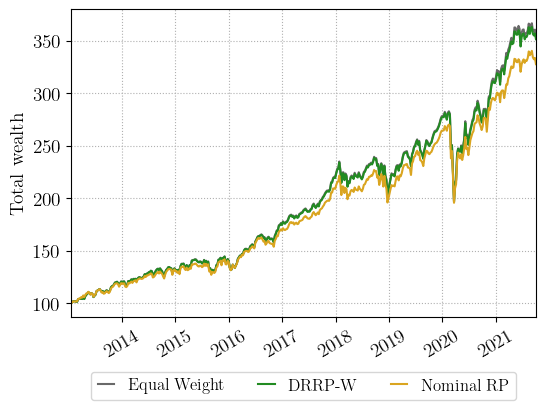

In [87]:
# dr_net.portfolio
#  'costa'
portfolio_list = [ew_net.portfolio, drrpw_net.portfolio, rp_net.portfolio]
portfolio_names = ['Equal Weight', 'DRRP-W', 'Nominal RP']
portfolio_colors = ["dimgray", "forestgreen", "goldenrod", "dodgerblue", "salmon"]
pf.wealth_plot(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/wealth_drrpw_delta0.3.pdf")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


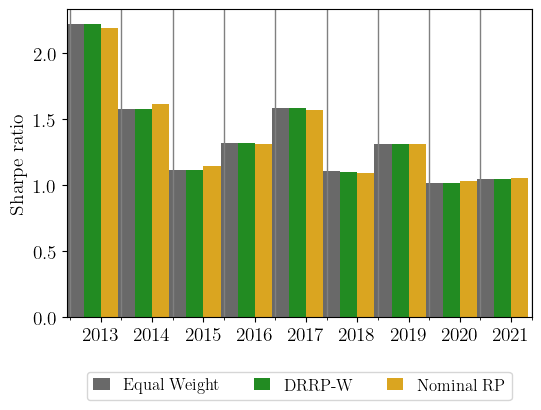

In [88]:
pf.sr_bar(portfolio_list, portfolio_names, portfolio_colors, 
                path=cache_path+"plots/sr_bar_drrp_delta0.3.pdf")

In [61]:
X.test()

,Mkt-RF,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev
Date,,,,,,,,
2011-01-21,-0.012406,-0.031176,0.002433,0.017686,0.001176,-0.018414,0.009953,-0.007394
2011-01-28,-0.003714,0.007098,-0.000813,-0.001410,-0.000813,0.011484,0.002086,-0.001843
2011-02-04,0.027689,0.004194,-0.007412,-0.007981,0.004806,0.012344,-0.003712,0.010708
2011-02-11,0.016674,0.010533,0.007291,-0.004010,0.006711,0.015879,-0.000419,0.012543
2011-02-18,0.010917,0.005693,0.005907,-0.003207,0.003898,-0.000233,-0.006019,0.005584
...,...,...,...,...,...,...,...,...
2021-08-27,0.021786,0.024208,-0.001256,-0.036350,0.000097,0.031023,0.020444,0.021506
2021-09-03,0.006809,-0.002356,-0.026389,-0.006528,-0.001031,-0.014881,-0.001408,-0.017647
2021-09-10,-0.017195,-0.008797,0.001300,-0.003973,-0.003608,-0.000295,0.002684,0.000863
